In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random

In [12]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sibling_directory = os.path.join(parent_directory,'data')
processed_directory = os.path.join(sibling_directory, 'processed')

In [14]:
feather_file_path1 = os.path.join(processed_directory, 'icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')
feather_file_path2 = os.path.join(processed_directory, 'icu_tabular_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')
df1 = feather.read_feather(feather_file_path1)
df1 = df1[['abs_event_time', 'stay_id', 'Arterial Blood Pressure mean','Sodium','Potassium','Creatinine','GCS - Eye Opening','GCS - Motor Response','GCS - Verbal Response']]
df2= feather.read_feather(feather_file_path2)
df2 = df2[['anchor_age', 'stay_id']]
merged_df = pd.merge(df1, df2, on='stay_id')
merged_df['abs_event_time'] = pd.to_datetime(merged_df['abs_event_time'])
print(merged_df.columns)


Index(['abs_event_time', 'stay_id', 'Arterial Blood Pressure mean', 'Sodium',
       'Potassium', 'Creatinine', 'GCS - Eye Opening', 'GCS - Motor Response',
       'GCS - Verbal Response', 'anchor_age'],
      dtype='object')


In [5]:
def calculate_APACHE_II(anchor_age,Arterial_Blood_Pressure_mean,Sodium,Potassium,Creatinine,GCS_Eye_Opening,GCS_Motor_Response,GCS_Verbal_Response):
    #APACHE II components
    Age_points = 0
    BP = 0
    Serum_sodium = 0
    Serum_potassium = 0
    Serum_creatinine = 0
    GCS_score = 0
    

    #age points
    if anchor_age >=75:
        Age_points = 6
    elif anchor_age >=65 and anchor_age <75:
        Age_points = 5
    elif anchor_age >=55 and anchor_age <65:
        Age_points = 3
    elif anchor_age >=45 and anchor_age <55:
        Age_points = 2
    elif anchor_age <45:
        Age_points = 0

    #Arterial blood pressure
    if Arterial_Blood_Pressure_mean >= 160 or Arterial_Blood_Pressure_mean < 50:
        BP = 4
    elif Arterial_Blood_Pressure_mean >= 130 and Arterial_Blood_Pressure_mean < 160:
        BP = 3
    elif Arterial_Blood_Pressure_mean >= 110 and Arterial_Blood_Pressure_mean < 130 or Arterial_Blood_Pressure_mean >= 50 and Arterial_Blood_Pressure_mean < 70:
        BP = 2
    elif Arterial_Blood_Pressure_mean >= 70 and Arterial_Blood_Pressure_mean < 110:
        BP = 0


    #Serium Sodium
    if Sodium >= 180 or Sodium <= 110:
        Serum_sodium = 4
    elif Sodium >= 160 and Sodium <180 or Sodium > 110 and Sodium < 120:
        Serum_sodium = 3
    elif Sodium >= 155 and Sodium <160 or Sodium >=120 and Sodium < 130:
        Serum_sodium = 2
    elif Sodium >= 150 and Sodium <155:
        Serum_sodium = 1
    elif Sodium >= 130 and Sodium <150:
        Serum_sodium = 0

    
    #Serum Potassium
    if Potassium >= 7.0 or Potassium < 2.5:
        Serum_potassium = 4
    elif Potassium >= 6.0 and Potassium < 7.0:
        Serum_potassium = 3
    elif Potassium >= 2.5 and Potassium < 3:
        Serum_potassium = 2
    elif Potassium >= 5.5 and Potassium < 6.0 or Potassium >= 3.0 and Potassium < 3.5:
        Serum_potassium = 1
    elif Potassium >= 3.5 and Potassium < 5.5:
        Serum_potassium = 0


    #Serum Creatinine
    if Creatinine >= 3.5:
        Serum_creatinine = 4
    elif Creatinine >= 2.0 and Creatinine < 3.5:
        Serum_creatinine = 3
    elif Creatinine >= 1.5 and Creatinine < 2.0 or Creatinine < 0.6:
        Serum_creatinine = 2
    elif Creatinine >= 0.6 and Creatinine < 1.5:
        Serum_creatinine = 0


    #Glasgow Coma Scale
    GCS_score = (15 - (GCS_Eye_Opening + GCS_Motor_Response + GCS_Verbal_Response))


    #Calculate modified APACHE score
    total_APACHE = Age_points + BP + Serum_sodium + Serum_potassium + Serum_creatinine + GCS_score

    return total_APACHE



In [6]:
# Forward fill missing values along each column
merged_df_ffilled = merged_df.ffill()

# Backward fill missing values along each column for initial 0 values
merged_df_filled = merged_df_ffilled.bfill()

# Calculate APACHE II scores for each row using filled data
merged_df_filled['APACHE_score'] = merged_df_filled.apply(lambda row: calculate_APACHE_II(row['anchor_age'], row['Arterial Blood Pressure mean'], row['Sodium'], row['Potassium'], row['Creatinine'], row['GCS - Eye Opening'], row['GCS - Motor Response'], row['GCS - Verbal Response']), axis=1)

# Display the dataframe with calculated APACHE II scores
print(merged_df_filled[['abs_event_time', 'stay_id',  'APACHE_score']])

          abs_event_time   stay_id  APACHE_score
0    1970-01-01 01:00:00  30057454           5.0
1    1970-01-01 02:00:00  30057454           5.0
2    1970-01-01 03:00:00  30057454           5.0
3    1970-01-01 04:00:00  30057454           5.0
4    1970-01-01 05:00:00  30057454           5.0
...                  ...       ...           ...
2911 1970-01-01 20:00:00  39880770           8.0
2912 1970-01-01 21:00:00  39880770           8.0
2913 1970-01-01 22:00:00  39880770           8.0
2914 1970-01-01 23:00:00  39880770           8.0
2915 1970-01-02 00:00:00  39880770           8.0

[2916 rows x 3 columns]


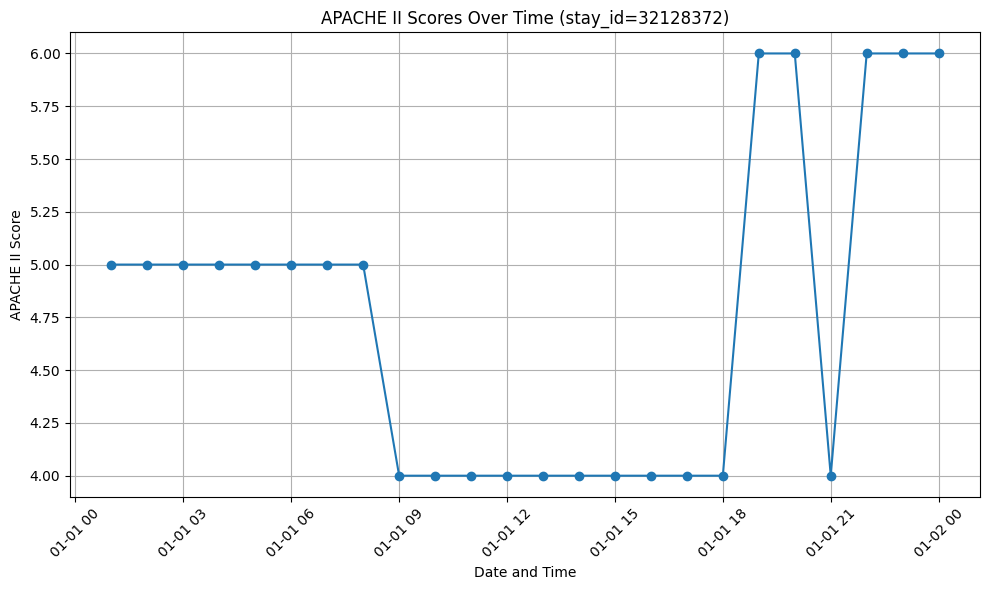

In [15]:
# Filter data for stay_id=32128372
filtered_df = merged_df_filled[merged_df_filled['stay_id'] == 30057454]

# Plot APACHE II scores for stay_id=32128372 over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['abs_event_time'], filtered_df['APACHE_score'], marker='o', linestyle='-')
plt.xlabel('Date and Time')
plt.ylabel('APACHE II Score')
plt.title('APACHE II Scores Over Time (stay_id=32128372)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#plt.xticks(pd.date_range(filtered_df['abs_event_time'].iloc[0], filtered_df['abs_event_time'].iloc[-1], periods=30))  # Set the number of ticks on the x-axis
plt.tight_layout() 
plt.grid(True)
plt.show()